# Import required packages

In [1]:
import os
import math
import glob
import cv2
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline

# Create a utility class for camera calibration

* This is used for calibrating camera and undistorting the images

In [2]:
class cam_util():
    """
        util class for camera operations
    """
    ret = None
    mtx = None
    dist = None
    rvecs = None
    tvecs = None
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    def gen_camera_points(self):
        """
            generate objpoints and impoints from calibration images
        """
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg')
        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)
                
    def undistort(self, img):
        """
            undistort an image with camera matrix
        """
        if self.mtx is None:
            self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints,
                                                                                        img.shape[:2],None,None)
        h,  w = img.shape[:2]
        newcameramtx, roi=cv2.getOptimalNewCameraMatrix(self.mtx, self.dist, (w,h), 1, (w,h))
        dst = cv2.undistort(img, self.mtx, self.dist, None, newcameramtx)
        x,y,w,h = roi
        return dst[y:y+h, x:x+w]
    
    def clean_mat(self):
        """
            Reset camera calibration
        """
        self.ret = None
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None

# Create a class to keep track of lane detections

* Here we use the average of last maxSamples to identify the lane

In [3]:
class Line():
    """
        class to store detected lane stats
    """
    def __init__(self, maxSamples=15):
        
        self.maxSamples = maxSamples 
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=self.maxSamples)
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # was the line detected in the last iteration?
        self.detected = False 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
         
    def update_lane(self, ally, allx):
        """
            Function to update the stats
        """
        # get the mean as the best x 
        self.bestx = np.mean(allx, axis=0)
        # fit a 2 order polynomial
        new_fit = np.polyfit(ally, allx, 2)
        # calculate the difference between last fit and new fit
        self.diffs = np.subtract(self.current_fit, new_fit)
        # update current fit
        self.current_fit = new_fit
        # add the new fit to the queue
        self.recent_xfitted.append(self.current_fit)
        # Use the queue mean as the best fit
        self.best_fit = np.mean(self.recent_xfitted, axis=0)
        # meters per pixel in y dimension
        ym_per_pix = 30/720
        # meters per pixel in x dimension
        xm_per_pix = 3.7/700
        # Calculate radius of curvature
        fit_cr = np.polyfit(ally*ym_per_pix, allx*xm_per_pix, 2)
        y_eval = np.max(ally)
        self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

In [4]:
# Utility Functions

def get_roi(img, vertices):
    """
        Apply mask and get region of interest within the mask
    """
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255 
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hide_roi(img, vertices):
    """
        Apply mask and get region of interest outside the mask
    """
    mask = np.zeros_like(img)
    mask=mask+255
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (0,) * channel_count
    else:
        ignore_mask_color = 0 
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def drow_on_images(img, vertices):
    """
        Draw ploygon on image
    """
    cv2.polylines(img, [vertices], True, (255,255,255), 2)
    plot_img(img, 'img drawing', True)

def plot_img(img, step, show_stages=False):
    """
        plot image
    """
    if show_stages:
        print('######################## '+step+' ########################')
        plt.imshow(img, cmap='gray')
        plt.show()
    
def plot_hist(histogram, show_stages=False):
    """
        plot histogram
    """
    if show_stages:
        print('######################## histogram ########################')
        plt.plot(histogram)
        plt.show()

# Use the lane pixals identified to fit a ploygon and draw it back on the original image

In [5]:
def write_stats(img):
    """
        Write lane stats on image
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    size = 1
    weight = 2
    color = (255,70,0)
    cv2.putText(img,'Left Curve : '+ '{0:.2f}'.format(left_line.radius_of_curvature)+' m',(10,30), font, size, color, weight)
    cv2.putText(img,'Right Curve : '+ '{0:.2f}'.format(right_line.radius_of_curvature)+' m',(10,60), font, size, color, weight)
    cv2.putText(img,'Left Lane Pos: '+ '{0:.2f}'.format(left_line.bestx),(10,100), font, size, color, weight)
    cv2.putText(img,'Right Lane Pos: '+ '{0:.2f}'.format(right_line.bestx),(10,130), font, size, color, weight)
    cv2.putText(img,'Distance from center: '+ "{0:.2f}".format(left_line.line_base_pos)+' m',(10,180), font, size, color, weight)
    
def draw_lane(undist, img, Minv):
    """
        Draw the detected lane bak on the image
    """
    # Generate x and y values for plotting
    ploty = np.linspace(300, 700)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fit = left_line.best_fit
    right_fit = right_line.best_fit
    
    if left_fit is not None and right_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (20,120, 80))
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.6, 0)
        write_stats(result)
        return result
    return undist

# Here we validate the detected lines and add them to the lane class

## A valid detection satisfies below rules

* Minmum number of pixals must be greater than 2000
* Left lane mean should be more than a minimum
* Right lane mean should be less then a minimum
* Lane width whoud be atlest 300 and atmost 800
* New detections must be within 100px of the average of last n detections 

In [6]:
def validate_Update_lane(img, nonzero, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, show_stages=False):
    """
        Validate the detected lane ids and update the lane stats if valid.
    """
    # Extract left and right line pixel positions
    left_line_allx = nonzerox[left_lane_inds]
    left_line_ally = nonzeroy[left_lane_inds] 
    right_line_allx = nonzerox[right_lane_inds]
    right_line_ally = nonzeroy[right_lane_inds]
    
    # Discard the detections if any of the detected lane is less than 2000 pixals. 
    # This is done because for very small size the poly fit function gives unpredictable results.
    # A better approch would be to use the largest lane curvature to extend the other one
    if len(left_line_allx) <= 2000 or len(right_line_allx) <= 2000:
        left_line.detected = False
        right_line.detected = False
        return
    
    left_x_mean = np.mean(left_line_allx, axis=0)
    right_x_mean = np.mean(right_line_allx, axis=0)
    lane_width = np.subtract(right_x_mean, left_x_mean)
    
    # Discard the detections if the lane with is too large or too small
    if left_x_mean > 450 or right_x_mean < 850:
        left_line.detected = False
        right_line.detected = False
        return
    if  lane_width < 300 or lane_width > 800:
        left_line.detected = False
        right_line.detected = False
        return 
    
    # Update the lane stats if the current detection is the first one or
    # the detection is within 100 pixals of the last n detection mean
    if left_line.bestx is None or np.abs(np.subtract(left_line.bestx, np.mean(left_line_allx, axis=0))) < 100:
        left_line.update_lane(left_line_ally, left_line_allx)
        left_line.detected = True
    else:
        left_line.detected = False
    if right_line.bestx is None or np.abs(np.subtract(right_line.bestx, np.mean(right_line_allx, axis=0))) < 100:
        right_line.update_lane(right_line_ally, right_line_allx)
        right_line.detected = True
    else:
        right_line.detected = False
    
    # Calculate the distance of car from center of lane
    lane_center = right_line.bestx - left_line.bestx
    left_line.line_base_pos = ((img.shape[1]*0.5 - lane_center)*3.7)/700
    right_line.line_base_pos = left_line.line_base_pos

# Find the lane using sliding window technique

* Use the minimum of bottom 1/4 of the histogram to find the initial left and right base
* Use the base points to find more points within a margin and min number of pixals
* Using 
* windows size = 9 
* margin = 80
* min pixals = 30

In [7]:
def window_search(img, nonzero, nonzerox, nonzeroy, show_stages=False):
    """
        Perform a sliding window search to detect lane pixals.
    """
    # Temp image to draw detections on
    out_img = np.dstack((img, img, img))*255
    # Calculate histogram
    histogram = np.sum(img[img.shape[0]*.75:,:], axis=0)
    plot_hist(histogram, show_stages)
    # Take the midpoint and use the max on each side as starting point
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[0:midpoint])
    rightx_base = np.argmax(histogram[midpoint:histogram.shape[0]]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low)
                          & (nonzeroy < win_y_high)
                          & (nonzerox >= win_xleft_low)
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low)
                           & (nonzeroy < win_y_high)
                           & (nonzerox >= win_xright_low)
                           & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds])) 
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    plot_img(out_img, 'sliding window marked', show_stages)
    return left_lane_inds, right_lane_inds

# Find Lanes Wrapper

* If left or right lane found in the last iteration. Get the pixals in a margin of 30 and validate

* If the validation fails or this is the first iteration use the sliding window technique to find lanes and then validate.

In [8]:
def find_lanes(img, show_stages=False):
    """
        Lane finding wrapper function
    """
    # Get the foreground pixals
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # If the last detection was successful take the non zero pixals within the 30 pixal margin as the new detections
    if left_line.detected and right_line.detected:
        margin = 30
        left_lane_inds = ((nonzerox > (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] - margin))
                          & (nonzerox < (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] - margin))
                           & (nonzerox < (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] + margin)))
        # Update the lane detections
        validate_Update_lane(img, nonzero, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    # If first detection or the last detection was unsuccessful perform a sliding window search
    else:
        #print('doing window search')
        left_lane_inds, right_lane_inds = window_search(img, nonzero, nonzerox, nonzeroy, show_stages)
        # Update the lane detections
        validate_Update_lane(img, nonzero, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)

# Warp the image to get birds' eye view

* Use source points
    * bounding_top_right = [img_shape[1]*0.5 + 90,img_shape[0]*0.70]
    * bounding_btm_right = [img_shape[1]*0.5 + 450,img_shape[0]]
    * bounding_btm_left  = [img_shape[1]*0.5 - 400,img_shape[0]]
    * bounding_top_left  = [img_shape[1]*0.5 - 60,img_shape[0]*0.70]

* Destinations points
    * bounding_top_right = [img_shape[1]*0.5 + 250,img_shape[0]*0.60]
    * bounding_btm_right = [img_shape[1]*0.5 + 390,img_shape[0]]
    * bounding_btm_left  = [img_shape[1]*0.5 - 345,img_shape[0]]
    * bounding_top_left  = [img_shape[1]*0.5 - 205,img_shape[0]*0.60]
    
* Get perpective transform
* Get inverse perpective transform
* warp the image using perspective transform


In [9]:
def warp(img):
    """
        Warp the image to get birds eye view.
    """
    img_shape = img.shape
    bounding_top_right = [img_shape[1]*0.5 + 90,img_shape[0]*0.70]
    bounding_btm_right = [img_shape[1]*0.5 + 450,img_shape[0]]
    bounding_btm_left  = [img_shape[1]*0.5 - 400,img_shape[0]]
    bounding_top_left  = [img_shape[1]*0.5 - 60,img_shape[0]*0.70]
    # Select source points
    pts1 = np.float32([bounding_top_right,bounding_btm_right,bounding_btm_left,bounding_top_left])
    # Select destination points
    pts2 = np.float32([[img_shape[1]*0.5 + 250,img_shape[0]*0.60],
                   [img_shape[1]*0.5 + 390,img_shape[0]],
                   [img_shape[1]*0.5 - 345,img_shape[0]],
                   [img_shape[1]*0.5 - 205,img_shape[0]*0.60]])
    # Get Perspective Transform 
    M = cv2.getPerspectiveTransform(pts1, pts2)
    # Get inverse Perspective Transform 
    Minv = cv2.getPerspectiveTransform(pts2, pts1)
    # Apply warp transform on source image
    dst = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return dst, Minv

# Threshold

* Use color threshold
    * The number of lane pixals must be considerably less than the background pixals and have a minimum value.
    * We use this to recursively increase or decrease the minimum threshold value to find the optimal value.
* Use Sobel operator to find gradients
* Combine the two to get the result

In [10]:
def rec_threshold(img, roi, t_min=140, t_max=255):
    """
        Funtion to apply recursive threshold with increasing/decreasing boundries
        based on the area of lane within a region of interest.
    """
    binary = np.zeros_like(img)
    binary[(img >= t_min) & (img <= t_max)] = 1
    # retrun last val if the threshold levels reach minimum or maximum.
    if t_min <= 40 or t_min >= 220:
        return binary
    binary_1 = get_roi(binary, roi)
    #print(np.sum(binary_1.nonzero()))
    if np.sum(binary_1.nonzero()) > 9800000:
        binary = rec_threshold(img, roi, t_min+10)
    elif np.sum(binary_1.nonzero()) < 100000:
        binary = rec_threshold(img, roi, t_min-10)    
    return binary

def threshold(img, roi, show_stages=False):
    """
        Apply threshold
    """
    # Convert image the HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Take v channel
    v_channel = hsv[:,:,2]
    plot_img(v_channel, 'v channel', show_stages)
    # Apply threshold to find lane
    v_binary = rec_threshold(v_channel, roi)
    plot_img(v_binary, 'color threshold', show_stages)

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x
    sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
    #sobelx = cv2.Sobel(sobelx, cv2.CV_32F, 0, 1) # Take the derivative 
    #plot_img(sobelx, show_stages)
    # Absolute x derivative to 
    abs_sobelx = np.absolute(sobelx)
    #accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #plot_img(sobelx, show_stages)
    sxbinary = np.zeros_like(scaled_sobel)
    # perform threshold
    sxbinary[(scaled_sobel >= 100) & (scaled_sobel <= 255)] = 1
    plot_img(sobelx, 'sobel', show_stages)
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, v_binary))
    combined_binary = np.zeros_like(sxbinary)
    # conbine color and sobel threshold
    combined_binary[(v_binary == 1) | (sxbinary == 1)] = 1
    plot_img(combined_binary, 'combined threshold', show_stages)
    return combined_binary

# Apply all the steps

* Undistort the image
* Apply perspective transform
* Apply threshold
* Find lanes
* Draw the result back on image

In [11]:
def process_image(image, show_stages=False):
    """
        Wrapper function for all image processing
    """
    # Undistort the image
    undistorted = cam.undistort(image)
    plot_img(undistorted, 'undistorted', show_stages)
    # Apply perpective transform
    img, Minv = warp(undistorted)
    plot_img(img, 'warped', show_stages)
    # Get points for region of interst
    vertices = np.array([[(image.shape[1]*0.1,image.shape[0]-50),
                        (image.shape[1]*0.5-100,image.shape[0]*0.60),
                        (image.shape[1]*0.5+100,image.shape[0]*0.60),
                        (image.shape[1]*0.95,image.shape[0]-50)]], 
                        dtype=np.int32)
    # Apply threshold
    img = threshold(img, vertices, show_stages)
    vertices = np.array([[(200,img.shape[0]),
                          (200,0),
                          (1050,0),
                          (1050,img.shape[0])]], dtype=np.int32)
    # Get roi
    img = get_roi(img, vertices)
    # Find Lanes
    find_lanes(img, show_stages)
    # Draw lanes on image
    res = draw_lane(undistorted, img, Minv);    
    #plot_img(res, show_stages)
    return res

# Generate obj points and img points

In [12]:
# init camera
cam = cam_util()
cam.gen_camera_points()

# Calibrate camera and undistort the chessbaord images 

In [13]:
# Undistort a sample calibration image
cal_dir = "camera_cal/"
cal_images = glob.glob(cal_dir+'*.jpg')

for cal_image in cal_images:
    cimg = mpimg.imread(cal_image)
    cimg_undistort = cam.undistort(cimg)
    cv2.imwrite('output_images/undistort_'+cal_image.split('/')[1],cimg_undistort)
print('calibration done')

calibration done


In [14]:
# Clean camera matrix
cam.clean_mat()

# Test on images

######################## Sample Stages ########################

######################## Initial ########################


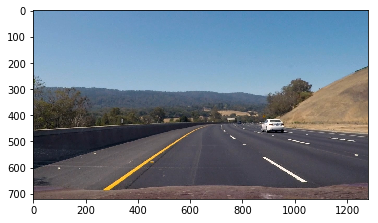

######################## undistorted ########################


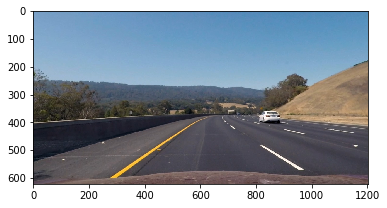

######################## warped ########################


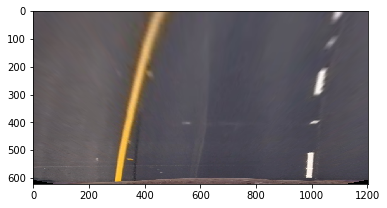

######################## v channel ########################


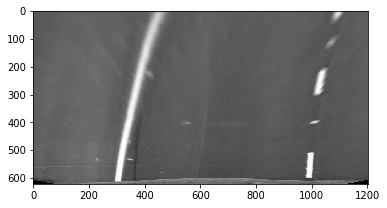

######################## color threshold ########################


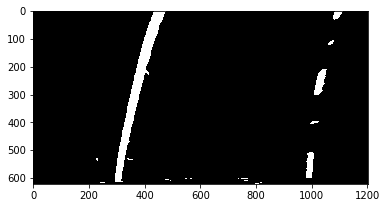

######################## sobel ########################


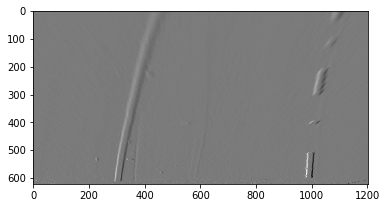

######################## combined threshold ########################


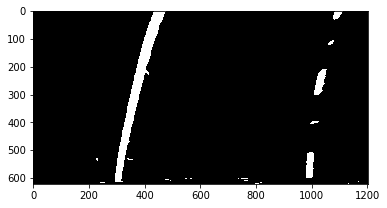

######################## histogram ########################


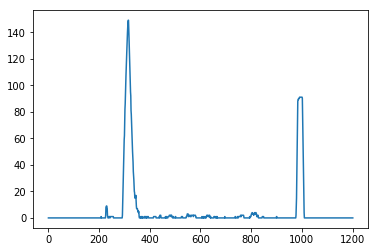

######################## sliding window marked ########################


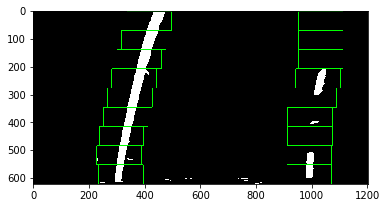

######################## Final ########################


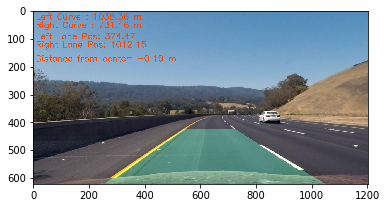

In [15]:
# Test on images
test_dir = "test_images/"
test_images = glob.glob(test_dir+'test*.jpg')
#test_images = glob.glob(test_dir+'straight_lines*.jpg')
#test_images = glob.glob(test_dir+'*.jpg')
for test_image in test_images:
    left_line = Line()
    right_line = Line()
    image = mpimg.imread(test_image)
    res = process_image(image, False)
    #plot_img(res, True)

print('######################## Sample Stages ########################')
print()
# display stages for a sample image
left_line = Line()
right_line = Line()
image = mpimg.imread('test_images/test3.jpg')
plot_img(image, 'Initial', True)
res = process_image(image, True)
plot_img(res, 'Final', True)

# Test on videos

In [16]:
# Test on Videos

# Clean data for video
#"""
left_line = Line()
right_line = Line()
cam.clean_mat()
project_video_res = 'project_video_res.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image)
project_video_clip.write_videofile(project_video_res, audio=False)
#"""

# Clean data for video
#"""
left_line = Line()
right_line = Line()
cam.clean_mat()
challenge_video_res = 'challenge_video_res.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
challenge_video_clip = clip2.fl_image(process_image)
challenge_video_clip.write_videofile(challenge_video_res, audio=False)
#"""

# Clean data for video
#"""
left_line = Line()
right_line = Line()
cam.clean_mat()
harder_challenge_video_res = 'harder_challenge_video_res.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
harder_challenge_video_clip = clip2.fl_image(process_image)
harder_challenge_video_clip.write_videofile(harder_challenge_video_res, audio=False)
#"""

[MoviePy] >>>> Building video project_video_res.mp4
[MoviePy] Writing video project_video_res.mp4


100%|█████████▉| 1260/1261 [03:41<00:00,  6.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_res.mp4 

[MoviePy] >>>> Building video challenge_video_res.mp4
[MoviePy] Writing video challenge_video_res.mp4


100%|██████████| 485/485 [01:36<00:00,  4.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_res.mp4 

[MoviePy] >>>> Building video harder_challenge_video_res.mp4
[MoviePy] Writing video harder_challenge_video_res.mp4


100%|█████████▉| 1199/1200 [04:16<00:00,  3.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_res.mp4 

